
<div style="
    background: linear-gradient(90deg, #c8102e 0%, #002868 100%);
    color: white;
    padding: 18px 22px;
    border-left: 6px solid #002868;
    border-right: 6px solid #c8102e;
    border-top: 3px solid #002868;
    border-bottom: 3px solid #002868;
    border-radius: 8px;
    box-shadow: 0 2px 8px rgba(0,0,0,0.18);
    font-family: 'Segoe UI', -apple-system, BlinkMacSystemFont, sans-serif;
">

  <h1 style="
      margin: 0 0 6px 0;
      font-size: 30px;
      font-weight: 700;
      letter-spacing: 0.03em;
      text-transform: uppercase;
      color: white;
  ">
Predicting Staple Food Prices in Haiti with Regression and Ensemble Models
  </h1>
</div>

<br></br>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats


from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

## **Preprocessing**

In [ ]:
# Load dataset
file_id = "1VyLHX20ofimGB7jhFhhw06MBu9Ajod4o"
url = f"https://drive.google.com/uc?download&id={file_id}"
haiti_df = pd.read_csv(url)
print(haiti_df.head())

         date  Department      City    market  latitude  longitude  \
0  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
1  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
2  2005-01-15  Artibonite  Gonaives  Gonaives     19.45 -72.683333   
3  2005-01-15      Centre    Hinche    Hinche     19.15 -72.016667   
4  2005-01-15      Centre    Hinche    Hinche     19.15 -72.016667   

            food_type               commodity     unit  usdprice  
0  cereals and tubers      Maize meal (local)  Marmite    0.4554  
1  cereals and tubers           Rice (tchako)  Marmite    0.7135  
2  cereals and tubers  Wheat flour (imported)  Marmite    0.4554  
3  cereals and tubers   Maize meal (imported)    Pound    0.0999  
4  cereals and tubers      Maize meal (local)  Marmite    0.2733  


In [ ]:
# Dataset dimension
haiti_df.shape

(14923, 10)

In [ ]:
# Check the data types
print(haiti_df.dtypes)

date           object
Department     object
City           object
market         object
latitude      float64
longitude     float64
food_type      object
commodity      object
unit           object
usdprice      float64
dtype: object


In [ ]:
# Convert date column to datetime data type
haiti_df['date'] = pd.to_datetime(haiti_df['date'])

print(haiti_df.dtypes)

date          datetime64[ns]
Department            object
City                  object
market                object
latitude             float64
longitude            float64
food_type             object
commodity             object
unit                  object
usdprice             float64
dtype: object


<hr style="background:linear-gradient(to right,blue,red)"> </hr>

#### Reasons for dropping the columns below:

 To avoid **multicollinearity**, `City` and `market` column will be dropped. Each city belongs to one department in Haiti, meaning that the `Department` column is a function of the `City` column. As for `market`, it is the same as `City`. If kept, they will inflate the model's variance.
   


<hr style="background:linear-gradient(to right,blue,red)"> </hr>

## **Model Development**

<br></br>

### Multiple Linear Regression

To stabilized the model's variance by compressing high-price values, the logarithmic will be applied on the `usdprice` feature.

In [ ]:
# Create interaction term
haiti_df["comm_per_dept"] = haiti_df["commodity"] + "_" + haiti_df["Department"]

# One-hot encode categorical features (including the new one)
features = ['commodity', 'Department', 'unit', 'food_type', 'comm_per_dept']
X = pd.get_dummies(haiti_df[features], drop_first=True)

# Target
y = np.log(haiti_df['usdprice'])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Evaluate
y_pred = lr.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)**0.5
r2 = r2_score(y_test, y_pred)

print("RMSE:", round(rmse, 3))
print("R^2 Score:", round(r2, 3))

RMSE: 0.537
R^2 Score: 0.785


* **$R^2$** : A score of 0.785 indicates that the model accounts for roughly 79% of the variation in Haiti’s food prices based on the selected predictors.

* **Root Mean Squared Error (RMSE)**: An average prediction error of about 0.54 (in log‑price units) reflects strong precision, especially given the wide differences in food prices across commodities and regions.



### Linear Regression Diagnostics

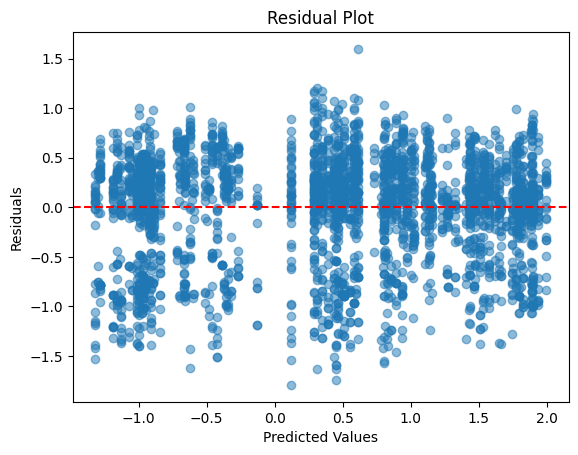

In [ ]:
# Residual plot
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

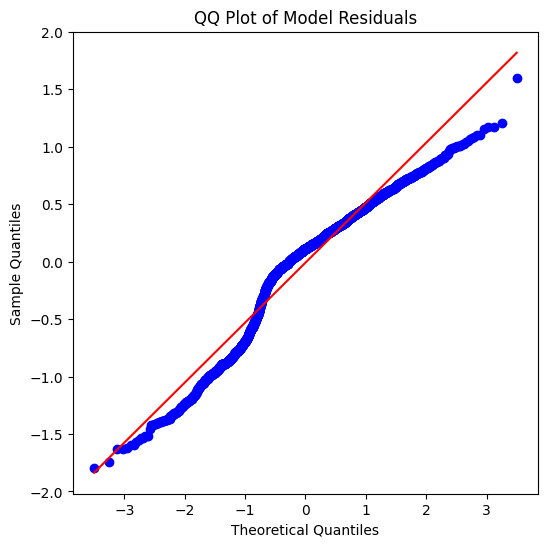

In [ ]:
# Compute residuals
residuals = y_test - y_pred

# QQ Plot
plt.figure(figsize=(6,6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Model Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
plt.show()


#### **Diagnostic Interpretation:**
The residual plot shows that prediction errors are randomly scattered around zero, with no visible pattern, suggesting that the model satisfies the assumptions of linearity and homoscedasticity. The QQ plot further confirms that residuals closely follow the theoretical normal distribution line, indicating that the errors are approximately normally distributed. Together, these diagnostics validate that the multiple linear regression model is statistically sound.

<br></br>

### Gradient Boost

In [ ]:
# Initialize and fit Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
gb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred2 = gb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred2)**0.5
r2 = r2_score(y_test, y_pred2)

print("Gradient Boosting Performance:")
print("RMSE (log scale):", round(rmse, 5))
print("R squared Score:", round(r2, 5))

Gradient Boosting Performance:
RMSE (log scale): 0.52623
R squared Score: 0.79302


<br></br>

### Random Forest Vs. XGBoost

In [ ]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize both models
n_estimators=100
xgb = XGBRegressor(n_estimators=n_estimators, random_state=42)
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=42)

# Fit models
xgb.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Measure prediciton for both models
y_pred_xgb = xgb.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Calulate the MSE and R^2 values for both models
rmse_xgb = mean_squared_error(y_test, y_pred_xgb)**0.5
r2_xgb = r2_score(y_test, y_pred_xgb)
rmse_rf = mean_squared_error(y_test,y_pred_rf)**0.5
r2_rf = r2_score(y_test, y_pred_rf)

# Print the MSE and R^2 values for both models
print(f'XGBoost:  RMSE = {rmse_xgb:.4f}, R^2 = {r2_xgb:.4f}')
print(f"Random Forest: RMSE = {rmse_rf:.4f}, R^2 = {r2_rf:.4f}")

XGBoost:  RMSE = 0.5261, R^2 = 0.7931
Random Forest: RMSE = 0.5261, R^2 = 0.7931




---



# **Model Comparison and Best Choice for Predicting Haiti's Food Price Variation**
Across all models, performance metrics fall within a tight range, but the differences reveal important insights about how each algorithm handles the structure of Haiti's food price data.
<br></br>
1. **Multiple Linear Regression (Log-transformation)**
* RMSE: 0.537
* $R$2: 0.785

Linear Regression provides a strong baseline but is limited by its linear assumptions. Haiti's food prices vary across commodities, regions, and measurement units in ways that are nonlinear and interaction‑heavy, which a linea regression cannot fully capture even with log‑transformation.
<br></br>

2. **Gradient Boosting**
* RMSE: 0.52623
* $R$2: 0.79302

Gradient Boosting improves meaningfully over LR by modeling nonlinearities and sequentially correcting errors. It captures more subtle structure in the data, but its performance is slightly behind the top models.
<br></br>

3. **Random Forest**
* RMSE: 0.5261
* $R$2: 0.7931
<br></br>

4. **XGBoost**
* RMSE: 0.5261
* $R$2: 0.7931

Random Forest and XGBoost achieve identical performance on this dataset.
<br></br>

## **Best Overall Model: XGBoost**
Even though Random Forest and XGBoost tie in metrics, XGBoost is the better choice for forecasting Haiti's food price variation.

#### **Reasons Why XGBoost is the best fit:**
* It handles sparse one‑hot encoded features more efficiently.

* It offers better control over regularization, reducing overfitting risk.

* It tends to generalize more consistently on tabular economic data.


Therefore, XGBoost is the recommended model for predicting Haiti's food price variation.

<br></br>

### Presented by:  
<a href="https://www.linkedin.com/in/carllegros/" target="_blank" style="color:blue"> Carl Legros</a>